# 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 2. Data preparation


## 2.1 Load data



In [3]:
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
y_train = train['label']

# Drop 'label' column
X_train = train.drop(labels= ['label'], axis= 1)

# free some space
del train 

# count of each digit in the train data
y_train.value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

##### we figure out that the data is balanced

## 2.2 Check for null and missing values

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

count: 784<br>
This means there are 784 values being checked for nulls. In the context of digit images (like the MNIST dataset), each image is typically represented as a 28x28 grid of pixels, which equals 28 * 28 = 784 pixels per image. So, you're likely checking nulls for each pixel value in a single image.

unique: 1<br>
There is only 1 unique value present in this data. This suggests that when you checked for nulls, only one value was found, and that value is False (i.e., there are no True values indicating nulls).

top: False<br>
The most frequent (or "top") value in this dataset is False, which indicates that no null values are present. If there were nulls, you'd expect to see True in this column.

freq: 784<br>
The frequency of the top value (False) is 784, meaning all 784 values are False. In other words, none of the pixel values in this image are null.

dtype: object<br>
The data type is being treated as an object in this summary, which is typical for boolean values like True and False in pandas.

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

I check for corrupted images (missing values inside).

There is no missing values in the train and test dataset. So we can safely go ahead.

## 2.3 Normalization

In [7]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

## 2.4 Reshape

In [8]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

## 2.5 Label encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

## 2.6 Split training and valdiation set


In [10]:
# Set the random seed
random_seed = 2

In [11]:
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_seed)

In [12]:
X_train[5].shape

(28, 28, 1)

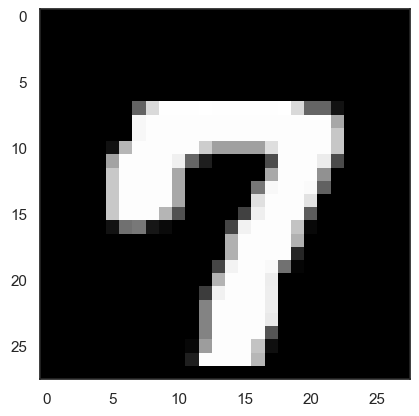

In [13]:
# Some examples
plt.imshow(X_train[5], cmap= 'gray')
plt.show()

## 3.1 Define the model

In [14]:
model = Sequential([
    Conv2D(filters= 32, kernel_size= (5,5), padding= 'Same',
           activation= 'relu', input_shape = (28,28,1)),
    Conv2D(filters= 32, kernel_size= (5,5), padding= 'Same',
           activation= 'relu'),
    MaxPool2D(pool_size= (2,2)),
    Dropout(0.25),


    Conv2D(filters= 64, kernel_size= (3,3), padding= 'Same',
           activation= 'relu'),
    Conv2D(filters= 64, kernel_size= (3,3), padding= 'Same',
           activation= 'relu'),
    MaxPool2D(pool_size= (2,2), strides=(2,2)),
    Dropout(0.25),


    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')

])

In [15]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

d:\Anaconda\envs\Tensorflow-gpu\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [17]:

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
epochs = 25
batch_size = 64

## 3.2 Data augmentation

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


For the data augmentation, i choosed to :

    Randomly rotate some training images by 10 degrees
    Randomly Zoom by 10% some training images
    Randomly shift images horizontally by 10% of the width
    Randomly shift images vertically by 10% of the height


I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

In [20]:

# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/25


C:\Users\PC\AppData\Local\Temp\ipykernel_23492\2641919697.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),


525/525 - 10s - loss: 0.3853 - accuracy: 0.8747 - val_loss: 0.0602 - val_accuracy: 0.9824 - lr: 0.0010 - 10s/epoch - 19ms/step
Epoch 2/25
525/525 - 7s - loss: 0.1232 - accuracy: 0.9634 - val_loss: 0.0446 - val_accuracy: 0.9873 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 3/25
525/525 - 6s - loss: 0.0924 - accuracy: 0.9726 - val_loss: 0.0363 - val_accuracy: 0.9885 - lr: 0.0010 - 6s/epoch - 12ms/step
Epoch 4/25
525/525 - 6s - loss: 0.0822 - accuracy: 0.9753 - val_loss: 0.0459 - val_accuracy: 0.9860 - lr: 0.0010 - 6s/epoch - 12ms/step
Epoch 5/25
525/525 - 6s - loss: 0.0730 - accuracy: 0.9781 - val_loss: 0.0304 - val_accuracy: 0.9917 - lr: 0.0010 - 6s/epoch - 12ms/step
Epoch 6/25
525/525 - 7s - loss: 0.0686 - accuracy: 0.9795 - val_loss: 0.0292 - val_accuracy: 0.9908 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 7/25
525/525 - 7s - loss: 0.0664 - accuracy: 0.9817 - val_loss: 0.0378 - val_accuracy: 0.9898 - lr: 0.0010 - 7s/epoch - 13ms/step
Epoch 8/25
525/525 - 7s - loss: 0.0642 - accuracy: 0.9818

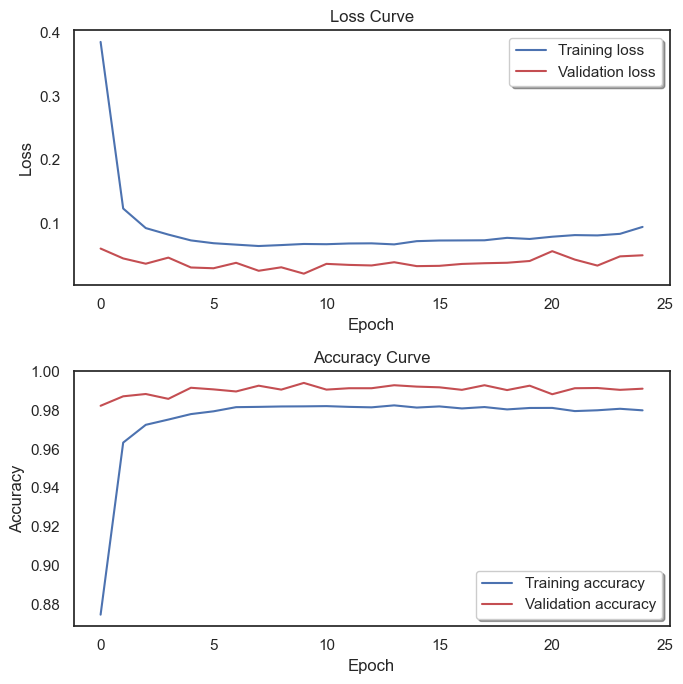

In [21]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(7, 7))  # Added figsize for better readability

# Plot loss
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best', shadow=True)

# Plot accuracy
ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')  # Use 'accuracy' instead of 'acc'
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')  # Use 'val_accuracy' instead of 'val_acc'
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best', shadow=True)

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()

In [22]:
# Save the model in TensorFlow's SavedModel format
model.save('handwritten_digit_recognition_model.h5')
